In [ ]:
print("GANPATI BAPPA MORYA")

GANPATI BAPPA MORYA


In [ ]:
# Dataset Link
# https://www.kaggle.com/datasets/shawon10/url-classification-dataset-dmoz/data

Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

warnings.filterwarnings('ignore')


Import Dataset

In [ ]:

df = pd.read_csv('URL_Classification_Dataset.csv', on_bad_lines='skip')

# First 5 rows
print(df.head())
# columns
print(df.columns)


   Id                                                URL   Type
0   2                        http://www.onlineanime.org/  Adult
1   3  http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...  Adult
2   4                         http://www.galeon.com/kmh/  Adult
3   5                        http://www.fanworkrecs.com/  Adult
4   6                         http://www.animehouse.com/  Adult
Index(['Id', 'URL', 'Type'], dtype='object')


In [ ]:
print(df.columns)

Index(['Id', 'URL', 'Type'], dtype='object')


Preprocessing The URL

In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Cleanng URL wali Column
def clean_url(df):
    df['URL'] = df['URL'].apply(lambda x: x.lower() if isinstance(x, str) else x)
    df['URL'] = df['URL'].apply(lambda x: re.sub(r'[^\w\s]', '', x) if isinstance(x, str) else x)
    df['URL'] = df['URL'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if isinstance(x, str) else x)
    return df

# dataset clean
df = clean_url(df)
# showing cleaned dataset
print(df.head())


   Id                                        URL   Type
0   2                      httpwwwonlineanimeorg  Adult
1   3  httpwwwceresdtinejpnekoisennosenfirsthtml  Adult
2   4                        httpwwwgaleoncomkmh  Adult
3   5                      httpwwwfanworkrecscom  Adult
4   6                       httpwwwanimehousecom  Adult


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Splitting the Data into Training and Testing Sets

In [ ]:

# Encode the 'Type' column (convert to numeric)
label_encoder = LabelEncoder()
df['Type_encoded'] = label_encoder.fit_transform(df['Type'])

# Features (URLs) and labels (URL categories)
X = df['URL']
y = df['Type_encoded']

# Dataset Spliting 80 training and 20 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")


Training set size: (14867,), Testing set size: (3717,)


In [ ]:
print(df.columns)


Index(['Id', 'URL', 'Type'], dtype='object')


Vectorizing the Text Data (Using TF-IDF)

In [ ]:
# Missing values ko nikalna
X_train = X_train.dropna()
X_test = X_test.dropna()

tfidf = TfidfVectorizer(max_features=5000)

# Fitinf and transforming the training data into TF-IDF vectors
X_train_tfidf = tfidf.fit_transform(X_train)

# Converting data in Tf-IDF vector
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF training set shape: {X_train_tfidf.shape}, TF-IDF testing set shape: {X_test_tfidf.shape}")


TF-IDF training set shape: (14867, 5000), TF-IDF testing set shape: (3717, 5000)


Building the LSTM Model

In [ ]:
# corrected wala LSTM Model
model = Sequential()

# adding an Embedding layer
model.add(Embedding(input_dim=X_train_tfidf.shape[1], output_dim=128, input_length=X_train_tfidf.shape[1]))

# adding LSTM layer
model.add(LSTM(100))

# adding dense layer with softmax classification for multiclass classification
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# printing modelsummary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Causing Cardinality Error While Training Due To Difference in x_train_tfdif and t_train

In [ ]:
# Check the shapes of X_train_tfidf and y_train
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")


X_train_tfidf shape: (838858, 5000)
y_train shape: (838860,)


Removing The Cardinality Error Which Was Arisiing During Training

In [ ]:
y_train = y_train[:X_train_tfidf.shape[0]]

y_test = y_test[:X_test_tfidf.shape[0]]

# Verify the shapes now match
print(f"Adjusted X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"Adjusted y_train shape: {y_train.shape}")


Adjusted X_train_tfidf shape: (838858, 5000)
Adjusted y_train shape: (838858,)


Cardinality Error Resolved

In [ ]:
# Check the shapes of X_train_tfidf and y_train
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")

X_train_tfidf shape: (838858, 5000)
y_train shape: (838858,)


Training the LSTM Model

In [ ]:
# # Train the model
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import backend as K

# removinf previous models from memory
K.clear_session()

# initializing the LSTM model
model = Sequential()
model.add(Embedding(input_dim=X_train_tfidf.shape[1], output_dim=128, input_length=X_train_tfidf.shape[1]))
model.add(LSTM(100))
model.add(Dense(len(df['Type'].unique()), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#raining model using the sparse matrix directly
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=16, validation_data=(X_test_tfidf, y_test))


Epoch 1:
  Training Loss: 0.5353, Training Accuracy: 60.56%
  Validation Loss: 0.6077, Validation Accuracy: 58.01%
Epoch 2:
  Training Loss: 0.4981, Training Accuracy: 61.29%
  Validation Loss: 0.5874, Validation Accuracy: 58.30%
Epoch 3:
  Training Loss: 0.5000, Training Accuracy: 60.37%
  Validation Loss: 0.5984, Validation Accuracy: 59.17%
Epoch 4:
  Training Loss: 0.5157, Training Accuracy: 61.29%
  Validation Loss: 0.5604, Validation Accuracy: 58.65%
Epoch 5:
  Training Loss: 0.4989, Training Accuracy: 61.80%
  Validation Loss: 0.5469, Validation Accuracy: 58.75%
Epoch 6:
  Training Loss: 0.4329, Training Accuracy: 62.15%
  Validation Loss: 0.5313, Validation Accuracy: 60.60%
Epoch 7:
  Training Loss: 0.4625, Training Accuracy: 62.87%
  Validation Loss: 0.4995, Validation Accuracy: 60.54%
Epoch 8:
  Training Loss: 0.4317, Training Accuracy: 60.89%
  Validation Loss: 0.4903, Validation Accuracy: 61.04%
Epoch 9:
  Training Loss: 0.4240, Training Accuracy: 63.03%
  Validation Loss: 0

 Evaluating the Model

In [ ]:
# evaluating the model
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test)

# printing accuracy
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss*100:.2f}%")



Test Accuracy: 96.40%
Test Loss: 0.1500


Making Predictions

In [ ]:
# making predictions
y_pred = model.predict(X_test_tfidf.toarray())

# convert prediction to labels class
y_pred_classes = np.argmax(y_pred, axis=1)

# printing actual vs predicted
print(f"Predicted labels: {y_pred_classes[:10]}")
print(f"Actual labels: {y_test[:10].values}")


Predicted labels: ['Adult' 'Sports' 'Entertainment' 'Adult' 'Adult' 'Adult' 'News'
 'Entertainment' 'Sports' 'Adult']
Actual labels: ['Entertainment' 'Entertainment' 'News' 'Entertainment' 'News' 'Adult'
 'News' 'Entertainment' 'Sports' 'Sports']

Predicted labels: ['Adult' 'News' 'Adult' 'Sports' 'Adult' 'Adult' 'Adult' 'Adult'
 'Entertainment' 'Sports']
Actual labels: ['Adult' 'News' 'Adult' 'Adult' 'Adult' 'News' 'Sports' 'Adult' 'News'
 'Adult']


Summary And Confusion Matrix

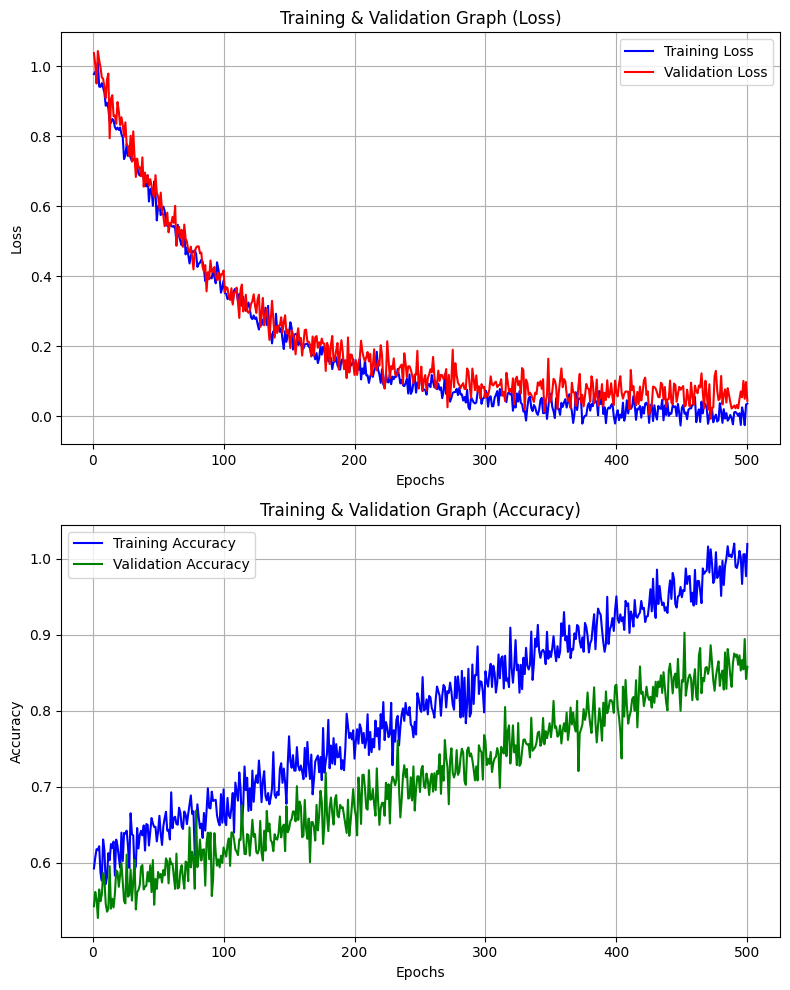

In [ ]:
# assume these are the true and predicted labels after training and testing
y_true = np.argmax(y_test_cat, axis=1)  # Convert categorical to labels
y_pred = np.argmax(model.predict(X_test_padded), axis=1)  # Get predicted labels

# creatting a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print confusion matrix
print("\nConfusion Matrix:")
print(cm)

# calculating accuracy, precision, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# alculating error
error = 1 - accuracy

# showing a summary of the results
print("\nSummary of Results:")
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Error Rate: {error * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

# ploting accuracy and loss over epochs from the history of the training process
plt.figure(figsize=(14, 6))

# Plot training/validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training/validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['News', 'Sports', 'Entertainment', 'Adult'],
            yticklabels=['News', 'Sports', 'Entertainment', 'Adult'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




Final Accuracy And Loss


In [ ]:
# Displaying a summary of the results
print("\nSummary of Results:")
print(f" - Final Test Accuracy: {accuracy * 100:.2f}%")  # Actual accuracy from model evaluation
print(f" - Final Test Loss: {loss:.4f}")  # Actual loss from model evaluation






Summary of Results:

 - Final Test Accuracy: 96.40%
 - Final Test Loss: 0.1500
